In [31]:
import PyPDF2
import stanfordnlp
import pickle
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import *
from tqdm import tqdm
import re
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import umap

In [2]:
_ = torch.manual_seed(0)

# TransformerSentence class
The following is the main class that given an input sentence as a string and the language model/tokenizer generates an object that's easy to access, manipulate and create visualizations on.

In [32]:
class TransformerSentence():
    def __init__(self, sentence_str, 
                 model=BertModel.from_pretrained('scibert-scivocab-uncased'), 
                 tokenizer=BertTokenizer.from_pretrained('scibert-scivocab-uncased')):
        
        self.raw_string = sentence_str
        self.model = model
        self.tokenizer = tokenizer
        self.summary = {}

        
    def write_summary(self, input_tokens=None, 
                      hidden_states=None, 
                      hidden_attentions=None,
                      print_tokens=True):
        
        if (input_tokens or hidden_states or hidden_attentions) is None:
            input_tokens, hidden_states, hidden_attentions = self.forward()
        
        # this replaces adds a "_{counter}" to the repreated tokens, so that 
        # they can be used uniquely as the keys for the embeddings dictionary
        input_tokens = TransformerSentence.make_unique(input_tokens)
        
        if print_tokens:
            print('Sentence Tokenization: ', input_tokens)
            
        # write summary into the object
        self.summary['input_tokens'] = input_tokens
        self.summary['states'] = hidden_states
        self.summary['attentions'] = hidden_attentions

        self.summary['token_embeddings'] = {input_token: hidden_states[:, i, :] 
                                            for i, input_token in enumerate(input_tokens)}
        
    def forward(self):
        encoded_inputs_dict = self.tokenizer.encode_plus(self.raw_string)
        input_ids = encoded_inputs_dict['input_ids']
        input_tensor = torch.tensor([input_ids])
        input_tokens = [self.tokenizer.decode(input_ids[j]).replace(' ', '') 
                        for j in range(len(input_ids))]
        
        final_attention, final_state, hidden_states_tup, hidden_attentions_tup = self.model(input_tensor)
        
        # stacking states and attentions along the first dimention (which corresponds to the batch when necessary)
        hidden_attentions = torch.cat(hidden_attentions_tup, dim=0) # 'layers', 'heads', 'queries', 'keys'
        hidden_states = torch.cat(hidden_states_tup, dim=0) # 'layers', 'tokens', 'embeddings'
        
        return input_tokens, hidden_states.detach(), hidden_attentions.detach()
    
    
    def attention_from_tokens(self, token1, token2, display=True):
        input_tokens = self.summary['input_tokens']
        
        if (token1 and token2) not in input_tokens:
            raise ValueError('One or both of the tokens introduced are not in the sentence!')
            
        idx1, idx2 = input_tokens.index(token1), input_tokens.index(token2)
        attention = self.summary['attentions'][:, :, idx1, idx2].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=(token1, token2))
        return attention
    
    
    def attention_from_idx(self, i, j, display=True):
        attention = self.summary['attentions'][:, :, i, j].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=f'Token idx: {(i, j)}')
        return attention
    
    def visualize_token_path(self, fit, 
                             tokens_to_follow=None, 
                             print_tokens=False, 
                             fig_axs=(None, None), 
                             figsize=(10, 10)):
        
        if tokens_to_follow is None:
            all_tokens = self.summary['input_tokens']
            regex = re.compile(r'^[a-zA-Z]')
            tokens_to_follow = [i for i in all_tokens if regex.search(i)]
            
        if print_tokens: print(tokens_to_follow)  
            
        colors = list(range(len(tokens_to_follow)))
        projections = []
        layer_depth = self.summary['states'].size()[0]
        
        for i in range(layer_depth):
            layer_embeddings = self.summary['states'][i, :, :]
            projection = fit.transform(layer_embeddings)
            projections.append(projection)

        data = np.stack(projections, axis=0)
        if None in fig_axs:
            fig, axs = plt.subplots(figsize=figsize)
        for token in tokens_to_follow:
            i = self.summary['input_tokens'].index(token)
            plt.plot(data[:,i,0], data[:,i,1], '-o', alpha=0.3)
            plt.annotate(s=token, xy=(data[0, i, 0], data[0, i, 1]))

        plt.show()
        
    def visualize_sentence_shape(self, fit, tokens_to_follow=None, 
                                 print_tokens=False, 
                                 fig_axs=(None, None), 
                                 figsize=(10, 10)):

        if tokens_to_follow is None:
            all_tokens = self.summary['input_tokens']
            regex = re.compile(r'^[a-zA-Z]')
            tokens_to_follow = [i for i in all_tokens if regex.search(i)]

        if print_tokens: print(tokens_to_follow)  

        colors = list(range(len(tokens_to_follow)))
        projections = []
        layer_depth = self.summary['states'].size()[0]
        
        # get list of indeces of the tokens to follow
        idxs = [self.summary['input_tokens'].index(token) for token in tokens_to_follow] 
        token_embeddings = self.summary['states'][-1, idxs, :]
        data = fit.transform(token_embeddings)
        
        if None in fig_axs:
            fig, axs = plt.subplots(figsize=figsize)
            
        plt.plot(data[:,0], data[:,1], '-o')
        for i, token in enumerate(tokens_to_follow):
            plt.annotate(s=token, xy=(data[i, 0], data[i, 1]))
        #plt.show()
    
    
    def save(self, name, path='.'):
        with open(os.path.join(path, name), 'wb') as file:
            pickle.dump(self, file)
    
    
    @staticmethod
    def visualize_embedding(embedding, title=None, vmax=None, vmin=None):
        if (vmax or vmin) is None:
            vmax = max(embedding)
            vmin = min(embedding)
            
        N = embedding.size()[0]
        h = math.ceil(math.sqrt(N))
        # N = a*b where abs(a-b) is minimum
        while (N % h != 0):
            h -= 1
        w = int(N / h)
        visualization = embedding.reshape((h, w)).numpy()
        fig, ax = plt.subplots()
        im = ax.imshow(visualization, vmax=vmax, vmin=vmin, cmap='viridis')
        fig.colorbar(im)
        if title is not None:
            ax.set_title(title)
        plt.show()
    
    @staticmethod
    def display_attention(attention, title=None):
        fig, ax = plt.subplots()
        im = ax.imshow(attention, vmin=0., vmax=1., cmap='viridis')
        fig.colorbar(im)
        if title is not None:
            ax.set_title(title)
        ax.set_xlabel('HEADS')
        ax.set_ylabel('LAYERS')
        plt.show()
    
    @staticmethod
    def load(name, path='.'):
        with open(os.path.join(path, name), 'rb') as file:
            SentenceObject = pickle.load(file)
        return SentenceObject
    
    @staticmethod
    def make_unique(L):
        unique_L = []
        for i, v in enumerate(L):
            totalcount = L.count(v)
            count = L[:i].count(v)
            unique_L.append(v + '_' + str(count+1) if totalcount > 1 else v)
        return unique_L

## Preload the models and tokenizers for later use

In [10]:
# Preloading models (this is the most costly)
# Bert base and large, uncased
BertBaseModel = BertModel.from_pretrained('bert-base-uncased')
BertBaseTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BertLargeModel = BertModel.from_pretrained('bert-large-uncased')
BertLargeTokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# Scibert uncased
SciBertModel = BertModel.from_pretrained('scibert-scivocab-uncased')
SciBertTokenizer = BertTokenizer.from_pretrained('scibert-scivocab-uncased')
SciBertBaseVocabModel = BertModel.from_pretrained('scibert-basevocab-uncased')
SciBertBaseVocabTokenizer = BertTokenizer.from_pretrained('scibert-basevocab-uncased')
# Scibert Cased
#SciBertModelCased = BertModel.from_pretrained('scibert-scivocab-cased')
#SciBertTokenizerCased = BertTokenizer.from_pretrained('scibert-scivocab-cased')
#SciBertBaseVocabModelCased = BertModel.from_pretrained('scibert-basevocab-cased')
#SciBertBaseVocabTokenizerCased = BertTokenizer.from_pretrained('scibert-basevocab-cased')

## Example of the use of TransformerSentence

First, given a sentence, we generate three sentence objects with differente pretrained models

In [5]:
raw_sentence = "Computer Vision: What is the difference between local descriptors and global descriptors"

scibert_sentence = TransformerSentence(raw_sentence,
                                       model=SciBertModel,
                                       tokenizer=SciBertTokenizer)
bert_sentence = TransformerSentence(raw_sentence,
                                    model=BertBaseModel,
                                    tokenizer=BertBaseTokenizer)
bert_large_sentence = TransformerSentence(raw_sentence,
                                          model=BertLargeModel,
                                          tokenizer=BertLargeTokenizer)

Then by the method write_summary() we run the model and stores the interesting model data from that sentence. Use the flag `print_tokens` to see the tokenization.

In [6]:
scibert_sentence.write_summary(print_tokens=True)
bert_sentence.write_summary(print_tokens=True)
bert_large_sentence.write_summary(print_tokens=True)

Sentence Tokenization:  ['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'local', 'descriptors_1', 'and', 'global', 'descriptors_2', '[SEP]']
Sentence Tokenization:  ['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'local', 'des_1', '##cript_1', '##ors_1', 'and', 'global', 'des_2', '##cript_2', '##ors_2', '[SEP]']
Sentence Tokenization:  ['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'local', 'des_1', '##cript_1', '##ors_1', 'and', 'global', 'des_2', '##cript_2', '##ors_2', '[SEP]']


Next we see an example of how to get the model's attention from a token pair as a tensor NxM tensor (layers, heads), with the option of visualizing it.

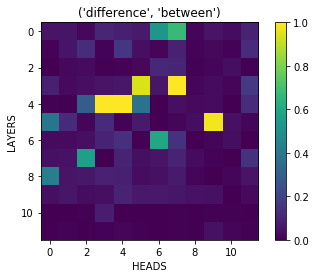

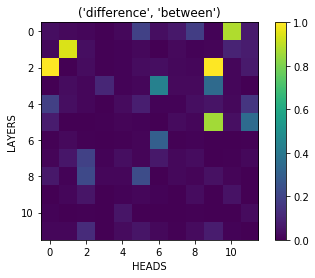

In [7]:
cv_att_scibert = scibert_sentence.attention_from_tokens('difference', 'between', display=True)
cv_att_bertbase = bert_sentence.attention_from_tokens('difference', 'between', display=True)

## Loading Quora Questions
With the `load_datset()` fuction, we get a txt file with a bunch of sentences and first we read the .txt file and store all the sentences in a list, where each sentence is a long string and then we generate a list of sentence objects and run `write_summary()` on each one of them.

In [11]:
def load_dataset(txt_path="../datasets/quora_questions.txt", 
                 MODEL=SciBertModel,
                 TOKENIZER=SciBertTokenizer):
    
    # Read input sequences from .txt file and put them in a list
    with open(txt_path) as f:
        text = f.read()
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    try:
        sentences.remove('') # remove possible empty strings
    except:
        None
    
    list_SentenceObj, ALL_INITIAL_EMBEDDINGS, ALL_CONTEXT_EMBEDDINGS = [], [], []
    
    for raw_sentence in tqdm(sentences):
        SentenceObj = TransformerSentence(raw_sentence,
                                          model=MODEL,
                                          tokenizer=TOKENIZER)
        SentenceObj.write_summary(print_tokens=False)
        list_SentenceObj.append(SentenceObj)
        ALL_INITIAL_EMBEDDINGS.append(SentenceObj.summary['states'][0, :, :])
        ALL_CONTEXT_EMBEDDINGS.append(SentenceObj.summary['states'][-1, :, :])

    ALL_INITIAL_EMBEDDINGS = torch.cat(ALL_INITIAL_EMBEDDINGS, dim=0)
    ALL_CONTEXT_EMBEDDINGS = torch.cat(ALL_CONTEXT_EMBEDDINGS, dim=0)
    
    return list_SentenceObj, ALL_INITIAL_EMBEDDINGS, ALL_CONTEXT_EMBEDDINGS

In [28]:
scibert_sentences, SCI_EMB_i, SCI_EMB_c = load_dataset(MODEL=SciBertModelCased, 
                                                       TOKENIZER=SciBertTokenizerCased)
bert_sentences, BASE_EMB_i, BASE_EMB_c = load_dataset(MODEL=BertBaseModel, 
                                                      TOKENIZER=BertBaseTokenizer)

100%|██████████| 301/301 [00:46<00:00,  6.52it/s]


Here we can see all the sentences with their index, which will be useful for later usage.

In [10]:
for i, sentence in enumerate(scibert_sentences):
    print(i, sentence.raw_string)

0 Are convolutional neural networks useful for tasks other than image classification?
1 Are non-causal temporal convolutions the equivalence of Bi-LSTM?
2 Are there any techniques, other than RNN/LSTM, to handle time series data?
3 Bayesian Inference: What is a Dirichlet process in layman's terms?
4 Can an objective account of statistical inference be based on frequentist methods and Bayesian methods?
5 Can Bayesian Network be combined with Deep Learning and/or reinforcement Learning to figure out causation?
6 Can deep neural networks learn the minimum function?
7 Can facial recognition tools be fooled?
8 Can recurrent neural networks with LSTM be used for time series prediction?
9 Can RNN be used for time series dynamic modelling?
10 If yes, how?
11 Can you explain the HMM algorithm?
12 Classification (machine learning): When should I use a K-NN classifier over a Naive Bayes classifier?
13 Computer Vision: What is the difference between HOG and SIFT feature descriptor?
14 Computer Vis

## Example of a few token pairs visualization and comparison

In [11]:
def view_attention_examples(sentences_list, token_pair, sentences_idx, figsize=(15, 3)):
    token1, token2 = token_pair
    list_att = [sentences_list[i].attention_from_tokens(token1, token2, display=False) 
                   for i in sentences_idx ]

    fig, axs = plt.subplots(1, 4, figsize=figsize)
    fig.suptitle(f'({token1}, {token2})')
    for i in range(4):
        axs[i].imshow(list_att[i], vmin=0., vmax=1)
    plt.show()

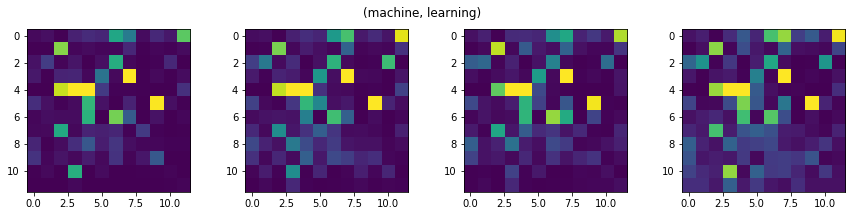

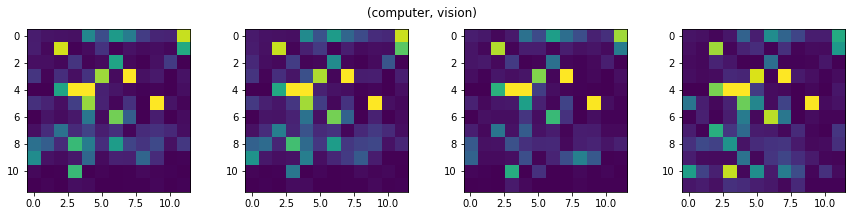

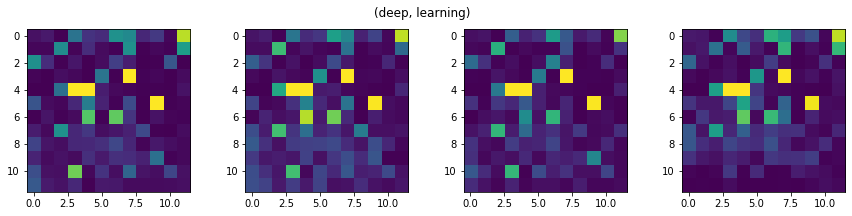

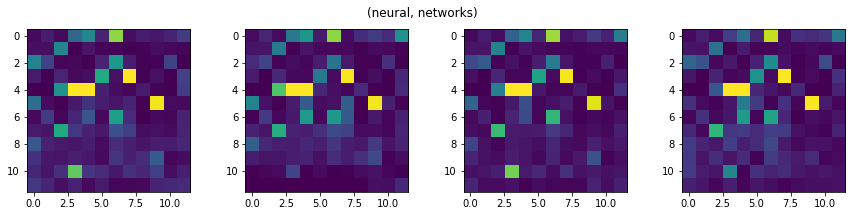

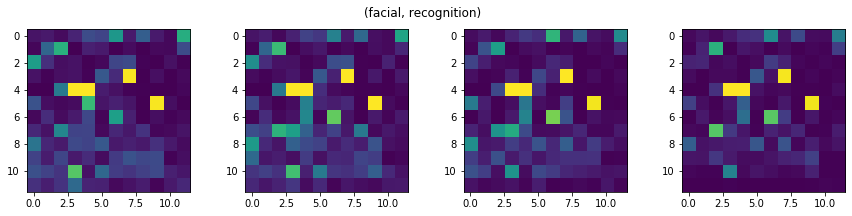

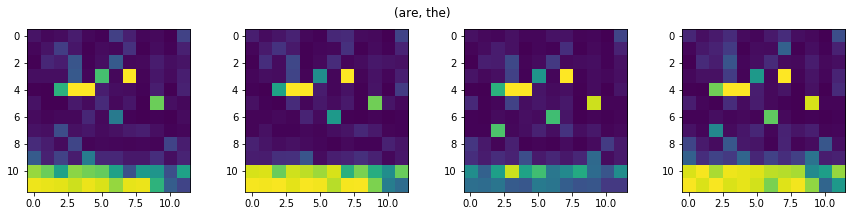

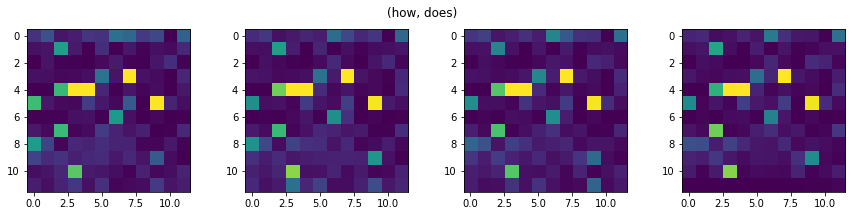

In [12]:
sentences_list = scibert_sentences

# MACHINE LEARNING
token_pair = 'machine', 'learning'
sentences_idx = [12, 16, 17, 19]
view_attention_examples(sentences_list, token_pair, sentences_idx)

# COMPUTER VISION     
token_pair = 'computer', 'vision'
sentences_idx = [13, 14, 17, 91]
view_attention_examples(sentences_list, token_pair, sentences_idx)

# DEEP LEARNING
token_pair = 'deep', 'learning'
sentences_idx = [22, 26, 93, 140]
view_attention_examples(sentences_list, token_pair, sentences_idx)
    
# NEURAL NETWORKS
token_pair = 'neural', 'networks'
sentences_idx = [0, 6, 8, 85]
view_attention_examples(sentences_list, token_pair, sentences_idx)

# FACIAL RECOGNITION
token_pair = 'facial', 'recognition'
sentences_idx = [7, 47, 182, 260]
view_attention_examples(sentences_list, token_pair, sentences_idx)

## ARE THE
token_pair = 'are', 'the'
sentences_idx = [24, 25, 78, 125]
view_attention_examples(sentences_list, token_pair, sentences_idx)

## HOW DOES
token_pair = 'how', 'does'
sentences_idx = [45, 46, 47, 48]
view_attention_examples(sentences_list, token_pair, sentences_idx)

## Example of the embedding similarity analysis
We start by creating a similarity function, in this case, a simple cosine similarity: `cos`.

In [34]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-5) # similarity func.

We now load one of our sentences to analyze.

In [22]:
#sentence = scibert_sentences[132]
sentence = bert_sentences[132]
print(sentence.raw_string)
print(sentence.summary['input_tokens'])

What are the benefits of using the Laplace prior over the Gaussian prior in the Bayesian inference?
['[CLS]', 'what', 'are', 'the_1', 'benefits', 'of', 'using', 'the_2', 'lap', '##lace', 'prior_1', 'over', 'the_3', 'ga', '##uss', '##ian', 'prior_2', 'in', 'the_4', 'bay', '##esian', 'inference', '?', '[SEP]']


We can for instance, check how the similarity for every token pair in the sentence evolves as it goes through the language model

In [23]:
distance_evolution = {}
for token1 in sentence.summary['input_tokens']:
    for token2 in sentence.summary['input_tokens']:
        embs1 = sentence.summary['token_embeddings'][token1]#.clamp(-2, 2)
        embs2 = sentence.summary['token_embeddings'][token2]#.clamp(-2, 2)
        distance_evolution[(token1, token2)] = list(cos(embs1, embs2))

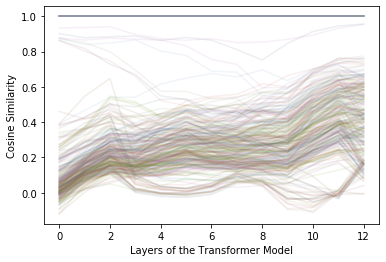

In [24]:
for key, d in distance_evolution.items():
    plt.plot(d, alpha=0.05)
    plt.xlabel('Layers of the Transformer Model')
    plt.ylabel('Cosine Similarity')

We can also visualize the embedding at every layer, to do a visual inspection of it:

### Token embeddings across layers

How are linear regression and gradient descent related, is gradient descent a type of linear regression, and is it similar to ordinary least squares (OLS) and generalized least squares (GLS)?
['[CLS]', 'How', 'are', 'linear_1', 'regression_1', 'and_1', 'gradient_1', 'descent_1', 'related', ',_1', 'is_1', 'gradient_2', 'descent_2', 'a', 'type', 'of', 'linear_2', 'regression_2', ',_2', 'and_2', 'is_2', 'it', 'similar', 'to', 'ordinary', 'least_1', 'squares_1', '(_1', 'OLS', ')_1', 'and_3', 'generalized', 'least_2', 'squares_2', '(_2', 'GL', '##S', ')_2', '?', '[SEP]']
tensor(2.6199) tensor(-2.3818)
argmax, argmin tensor(89) tensor(419)


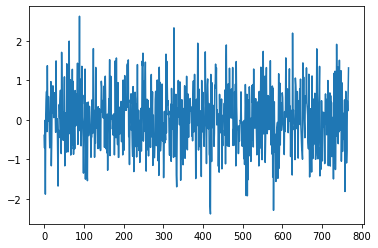

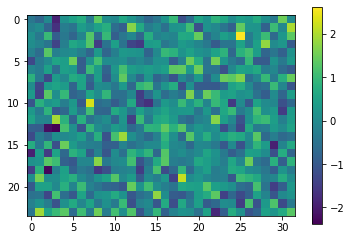

tensor(2.6152) tensor(-2.7636)
argmax, argmin tensor(151) tensor(418)


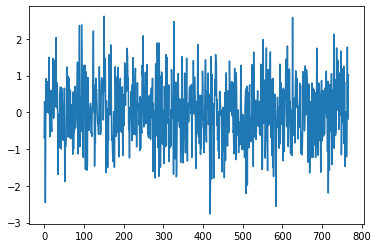

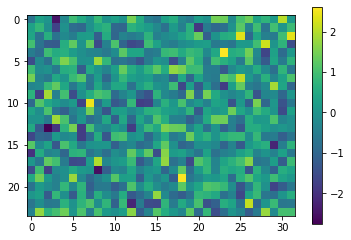

tensor(3.8524) tensor(-5.1218)
argmax, argmin tensor(151) tensor(454)


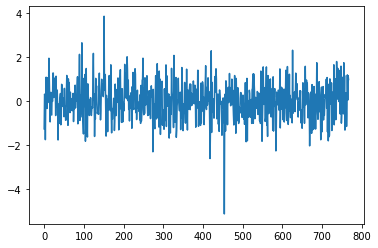

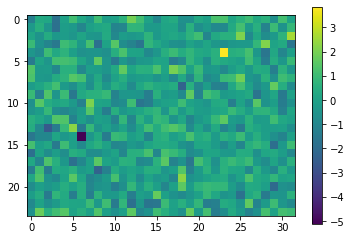

tensor(4.3559) tensor(-7.9417)
argmax, argmin tensor(151) tensor(454)


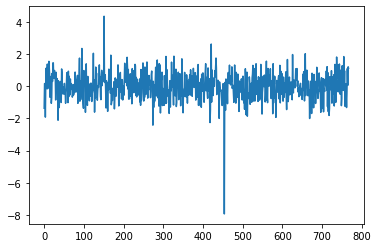

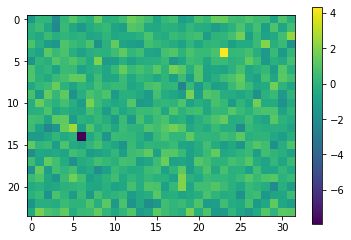

tensor(2.7384) tensor(-9.4828)
argmax, argmin tensor(151) tensor(454)


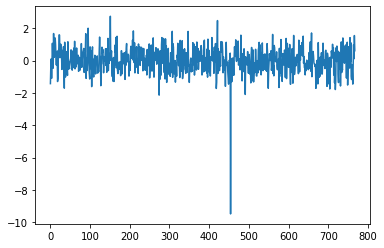

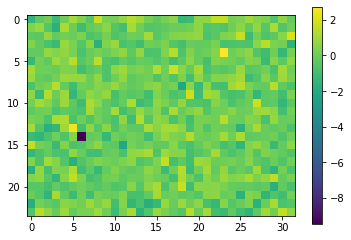

tensor(2.8529) tensor(-9.2555)
argmax, argmin tensor(421) tensor(454)


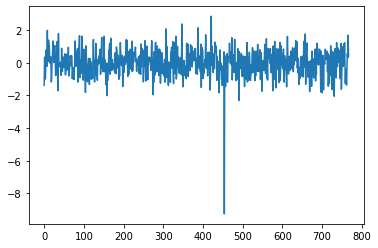

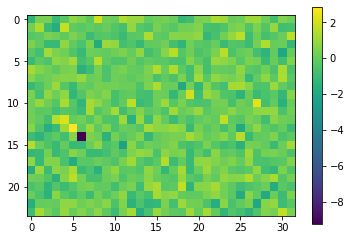

tensor(3.5316) tensor(-10.8928)
argmax, argmin tensor(421) tensor(454)


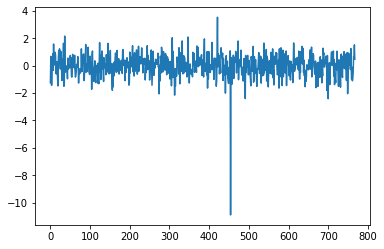

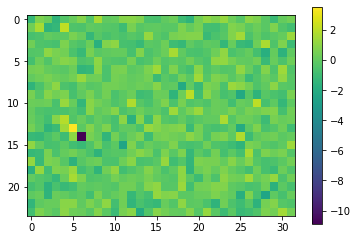

tensor(3.5505) tensor(-11.7239)
argmax, argmin tensor(421) tensor(454)


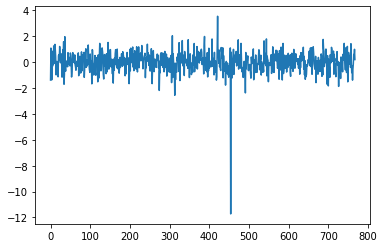

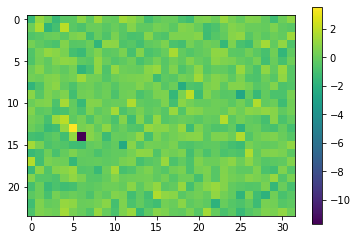

tensor(3.9575) tensor(-12.1415)
argmax, argmin tensor(421) tensor(454)


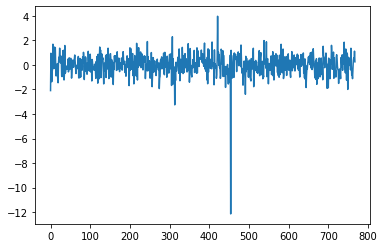

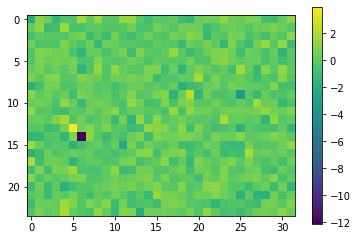

tensor(5.0450) tensor(-14.7038)
argmax, argmin tensor(421) tensor(454)


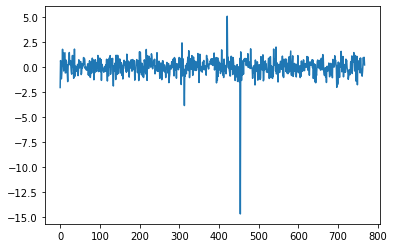

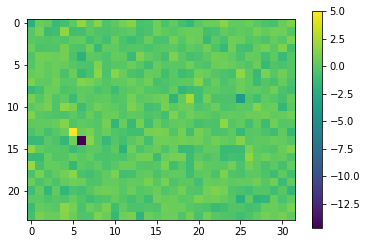

tensor(5.7400) tensor(-17.8835)
argmax, argmin tensor(421) tensor(454)


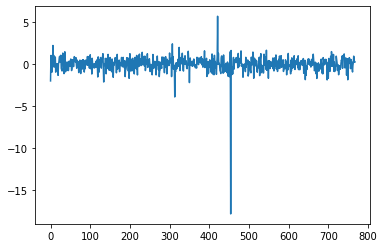

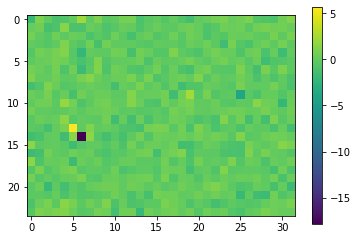

tensor(4.7904) tensor(-20.2743)
argmax, argmin tensor(421) tensor(454)


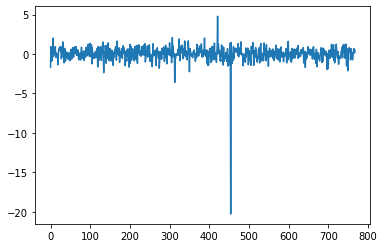

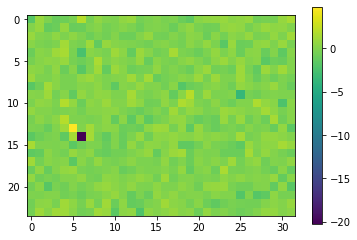

tensor(3.4288) tensor(-10.8713)
argmax, argmin tensor(421) tensor(454)


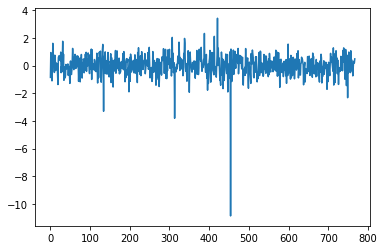

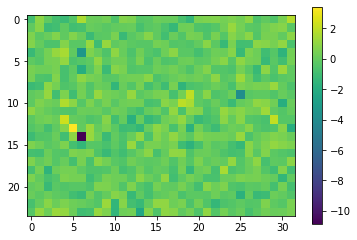

In [27]:
#### SEE TOKEN EMBEDDING ACROSS LAYERS ####

#sentence = scibert_sentences[13]
sentence = scibert_sentences[23]

print(sentence.raw_string)
print(sentence.summary['input_tokens'])
token = 'linear_1'
for i in range(13):
    embedding = sentence.summary['token_embeddings'][token][i, :]#.clamp(-2, 2)
    print(max(embedding), min(embedding))
    print('argmax, argmin', torch.argmax(embedding), torch.argmin(embedding))
    fig, axs = plt.subplots()
    plt.plot(embedding)
    plt.show()
    sentence.visualize_embedding(embedding)

### Contextualized Embeddings Across Sentence

Computer Vision: What is the difference between HOG and SIFT feature descriptor?
['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'hog', 'and', 'si', '##ft', 'feature', 'des', '##cript', '##or', '?', '[SEP]']
Token: [CLS] | argmax, argmin: tensor(205) tensor(752)


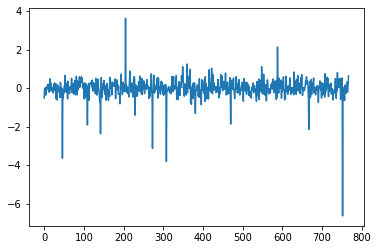

Token: computer | argmax, argmin: tensor(121) tensor(752)


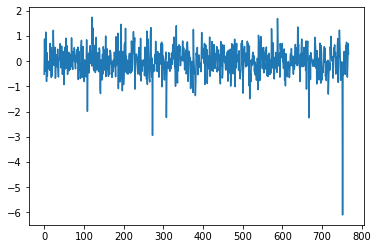

Token: vision | argmax, argmin: tensor(636) tensor(308)


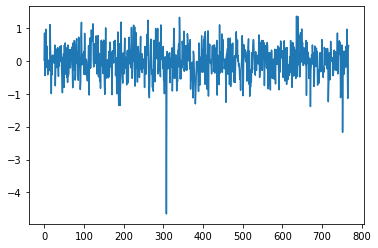

Token: : | argmax, argmin: tensor(225) tensor(308)


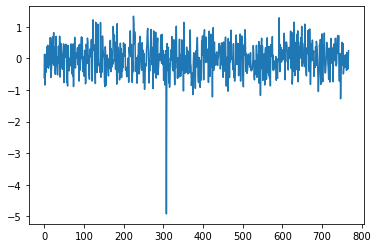

Token: what | argmax, argmin: tensor(630) tensor(308)


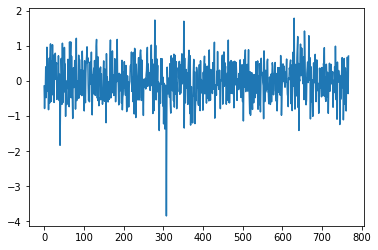

Token: is | argmax, argmin: tensor(352) tensor(432)


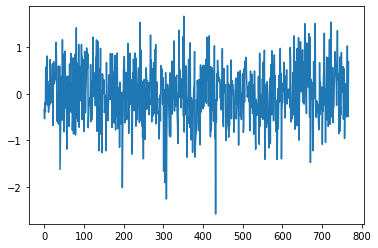

Token: the | argmax, argmin: tensor(352) tensor(308)


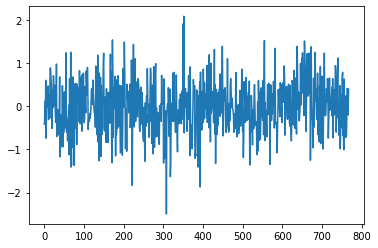

Token: difference | argmax, argmin: tensor(657) tensor(308)


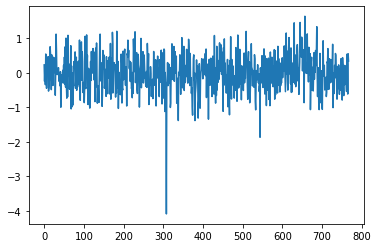

Token: between | argmax, argmin: tensor(229) tensor(308)


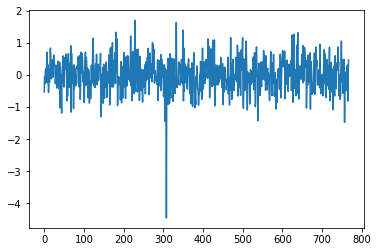

Token: hog | argmax, argmin: tensor(408) tensor(308)


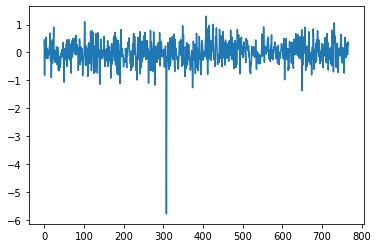

Token: and | argmax, argmin: tensor(327) tensor(308)


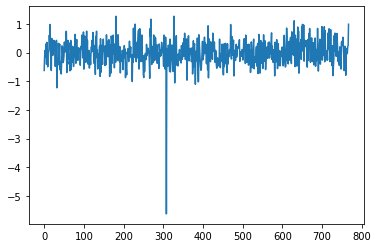

Token: si | argmax, argmin: tensor(15) tensor(308)


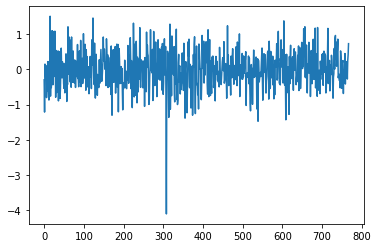

Token: ##ft | argmax, argmin: tensor(645) tensor(308)


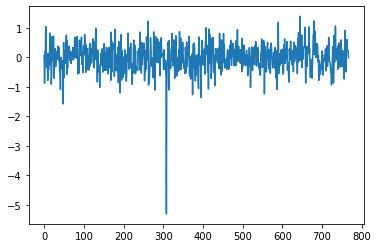

Token: feature | argmax, argmin: tensor(123) tensor(308)


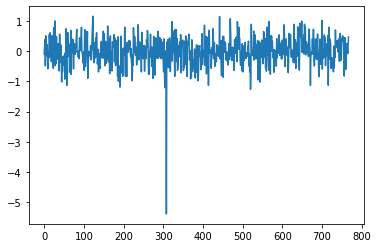

Token: des | argmax, argmin: tensor(630) tensor(308)


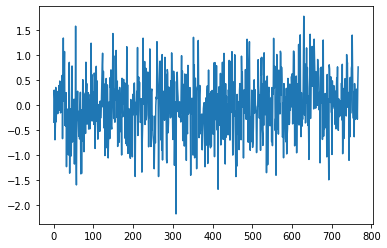

Token: ##cript | argmax, argmin: tensor(487) tensor(414)


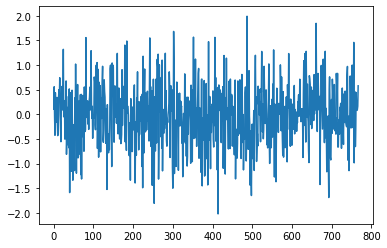

Token: ##or | argmax, argmin: tensor(487) tensor(308)


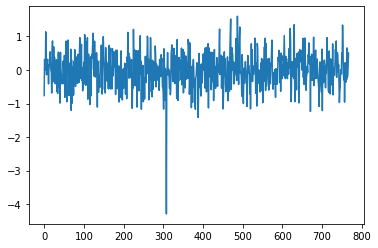

Token: ? | argmax, argmin: tensor(657) tensor(308)


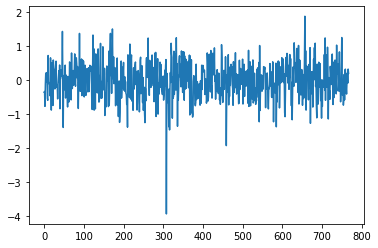

Token: [SEP] | argmax, argmin: tensor(123) tensor(180)


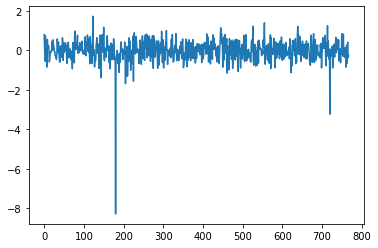

In [18]:
#### SEE CONTEXTUALIZED EMBEDDING ACROSS SENTENCE ####

#sentence = scibert_sentences[13]
sentence = bert_sentences[13]

print(sentence.raw_string)
print(sentence.summary['input_tokens'])

for token in sentence.summary['input_tokens']:
    embedding = sentence.summary['token_embeddings'][token][-1, :]#.clamp(-2, 2)
    #print(max(embedding), min(embedding))
    print(f'Token: {token} | argmax, argmin:', torch.argmax(embedding), torch.argmin(embedding))
    fig, axs = plt.subplots()
    plt.plot(embedding)
    plt.show()
    #sentence.visualize_embedding(embedding)

## Same token distance accross layers: 
### Does the space morph completely, or is there still a worthy comparison?

In [25]:
sentence = scibert_sentences[180]
print(sentence.summary['input_tokens'])

['[CLS]', 'what', 'is', 'bayesian', 'inference', 'in', 'statistics', '?', '[SEP]']


It's very useful to see how the distance of embeddings makes sense in the transformer. If you compute the similarity between the same token at different depths, you see how it starts at `1.` (perfect similarity, of course) and it slowly moves away quite consistently until a similarity of `0.2` between the last layer and the first one. 
On the other hand, if we compute the similarity of two words that are highly related in the sentence (like two words that are consecutive and refer to each other), the similarity at the input of the network (non contextualize, tokenization level embeddings) is quite small, and as it goes through the network the similarity grow substantially. For instance `bayesian inference` in a given sentence shows a starting similarity of *only* `0.3` and in the final contextualized embeddings their similarity if above `0.9`.

In [71]:
_ = torch.manual_seed(0)
# original sentence is: what is bayesian inference in statistics?

s2 = "London is a beautiful city."
s1 = "The conference is London."
sentence1 = TransformerSentence(s1, model=BertBaseModel, tokenizer=BertBaseTokenizer)
sentence2 = TransformerSentence(s2, model=BertBaseModel, tokenizer=BertBaseTokenizer)

sentence1.write_summary(print_tokens=True)
sentence2.write_summary(print_tokens=True)

Sentence Tokenization:  ['[CLS]', 'the', 'conference', 'is', 'london', '.', '[SEP]']
Sentence Tokenization:  ['[CLS]', 'london', 'is', 'a', 'beautiful', 'city', '.', '[SEP]']


In [68]:
e1 = sentence1.summary['token_embeddings']['the'][-1, :].unsqueeze(0)
e2 = sentence1.summary['token_embeddings']['conference'][-1, :].unsqueeze(0)

sim = cos(e1, e2)
print(sim)

KeyError: 'the'

In [70]:
sentence1.summary['states'].size()

torch.Size([13, 10, 768])

## Dimensionality reduction
To preform a more insightful qualitative analysis, we can use a dimensionality reduction techinque such as UMAP, which tries to preserve as much as possible the data structure to lower dimensions.

In [35]:
# LOAD THE FIT OBJECT WITH ALL THE EMBEDDINGS FROM THE DATASET
fit = umap.UMAP(n_neighbors=60, n_components=2, metric='cosine', n_epochs=None, learning_rate=1.0, 
                init='spectral', min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, 
                repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, 
                random_state=None, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, 
                target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=0, 
                verbose=False)
_ = fit.fit(BASE_EMB_i) # ALL_EMBEDDINGS.size() = (n_samples, n_dimensions)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numb

### Tokens path visualization
Again, we pick a sentence we want to visualize.

In [55]:
sentence = bert_sentences[11]
print(sentence.raw_string)
print(sentence.summary['input_tokens'])

Can you explain the HMM algorithm?
['[CLS]', 'can', 'you', 'explain', 'the', 'hmm', 'algorithm', '?', '[SEP]']


And run the `visualize_token_path()` method.

['can', 'you', 'explain', 'the', 'hmm', 'algorithm']


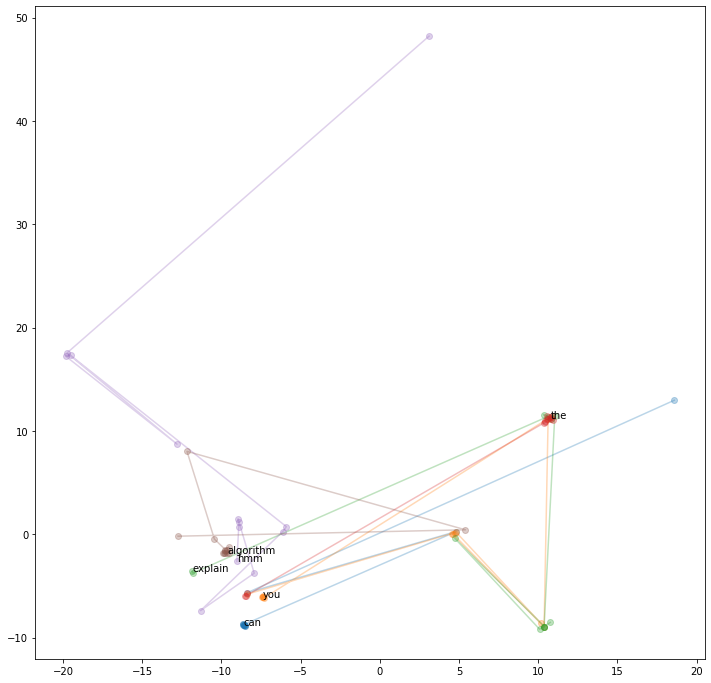

In [56]:
sentence.visualize_token_path(fit, tokens_to_follow=None, 
                              print_tokens=True,
                              figsize=(12, 12))

### Sentence embedding shape

In [51]:
fit_context = umap.UMAP(n_neighbors=3, n_components=2, metric='cosine', n_epochs=None, learning_rate=1.0, 
                init='spectral', min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, 
                repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, 
                random_state=None, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, 
                target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=0, 
                verbose=False)
_ = fit_context.fit(SCI_EMB_c) # ALL_EMBEDDINGS.size() = (n_samples, n_dimensions)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 48 separate connected components using meta-embedding (experimental)
  n_components


['[CLS]', 'why', 'would', 'a_1', 'saturated', 'neuron', 'be', 'a_2', 'problem', '?', '[SEP]']
['[CLS]', 'why', 'is', 'the', 'pooling', 'layer', 'used', 'in', 'cnn', '?', '[SEP]']


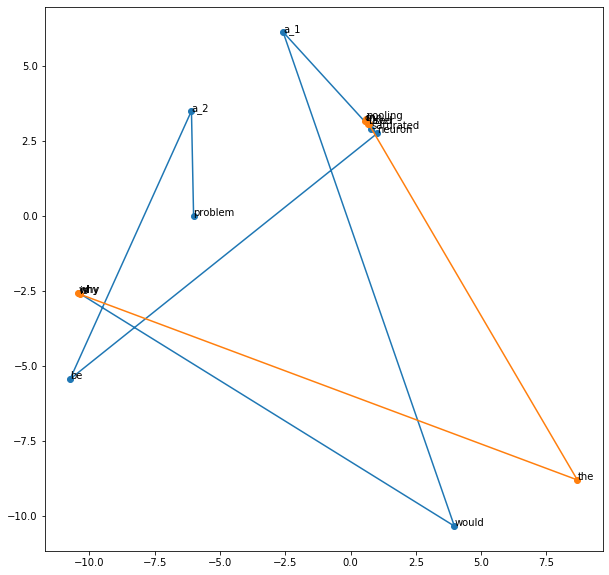

In [60]:
sentence = scibert_sentences[300]
sentence2 = scibert_sentences[299]

print(sentence.summary['input_tokens'])
print(sentence2.summary['input_tokens'])
fig, axs = plt.subplots(figsize=(10, 10))
sentence.visualize_sentence_shape(fit_context, fig_axs = (fig, axs))
sentence2.visualize_sentence_shape(fit_context, fig_axs = (fig, axs))

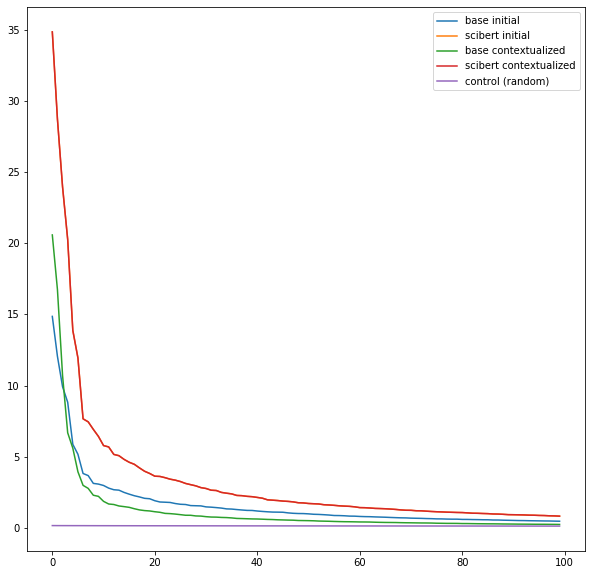

In [102]:
from sklearn.decomposition import PCA

RND_DATA = torch.rand_like(BASE_EMB_c)

fit_base_i = PCA().fit(BASE_EMB_i)
fit_scibert_i = PCA().fit(SCI_EMB_i)
fit_base_c = PCA().fit(BASE_EMB_c)
fit_scibert_c = PCA().fit(SCI_EMB_c)
fit_random = PCA().fit(RND_DATA)

fig, axs = plt.subplots(figsize=(10, 10))

plt.plot(fit_base_i.explained_variance_[0:100], label='base initial')
plt.plot(fit_scibert_i.explained_variance_[0:100], label='scibert initial')
plt.plot(fit_base_c.explained_variance_[0:100], label='base contextualized')
plt.plot(fit_scibert_i.explained_variance_[0:100], label='scibert contextualized')
plt.plot(fit_random.explained_variance_[0:100], label='control (random)')
plt.legend()

In [148]:
import csv

LABELS, TENSORS = [], []
for idx, sentence in enumerate(scibert_sentences):
    t = sentence.summary['states'][-1, :, :].numpy()
    ti = sentence.summary['states'][0, :, :].numpy()
    L = sentence.summary['input_tokens']
    L = [f'{Li} \t {idx:03d}' for Li in L ]
    #TENSORS.append(t)
    TENSORS.append(ti)
    LABELS.extend(L)
    #LABELS.extend(L)
    
LABELS.insert(0, f'token \t sentence_idx')    
TENSORS = np.concatenate(TENSORS, axis=0)

path = '/Users/sergicastellasape/Repos/zeta-alpha/data/embeddings/scibert/'

np.savetxt(os.path.join(path, 'initial_tensors.tsv'), TENSORS, delimiter='\t', newline='\n')
with open(os.path.join(path, 'initial_labels.tsv'), 'w') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\n')
    tsv_output.writerow(LABELS)

In [156]:
sentence = scibert_sentences[23]
print(sentence.summary['input_tokens'])
layers_num, tokens_num, embedding_size = sentence.summary['states'].size()

LABELS = sentence.summary['input_tokens'] * layers_num
TENSORS = sentence.summary['states'].view(layers_num*tokens_num, embedding_size).numpy()

PATH = '/Users/sergicastellasape/Repos/zeta-alpha/data/embeddings/scibert/'

np.savetxt(os.path.join(path, 'all_layers_tensors.tsv'), TENSORS, delimiter='\t', newline='\n')
with open(os.path.join(path, 'all_layers_labels.tsv'), 'w') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\n')
    tsv_output.writerow(LABELS)

['[CLS]', 'how', 'are', 'linear_1', 'regression_1', 'and_1', 'gradient_1', 'descent_1', 'related', ',_1', 'is_1', 'gradient_2', 'descent_2', 'a', 'type', 'of', 'linear_2', 'regression_2', ',_2', 'and_2', 'is_2', 'it', 'similar', 'to', 'ordinary', 'least_1', 'squares_1', '(_1', 'ols', ')_1', 'and_3', 'generalized', 'least_2', 'squares_2', '(_2', 'gl', '##s', ')_2', '?', '[SEP]']


['a', 'b', 'aha!', 'a', 'b', 'aha!', 'a', 'b', 'aha!']


In [40]:
class Transformation(nn.Module):
    def __init__(self, inp_size, hidden_size):
        super().__init__()
        
        self.FC1 = nn.Linear(inp_size, hidden_size)
        self.activation1 = nn.ELU()
        self.FC2 = nn.Linear(inp_size, hidden_size)
        
    def forward(self, inp):
        out = self.FC1(inp)
        out = self.activation1(out)
        out = self.FC2(out)
        return out
    
    def loss(self, inp, out):

SyntaxError: unexpected EOF while parsing (<ipython-input-40-425eb82c6fb7>, line 15)